In [17]:
# autoreload
%load_ext autoreload
%autoreload 2

import scTRS.method_simple as simple_md
import scTRS.util as util
import scTRS.method as md
import scTRS.data_loader as dl
import submitit
import numpy as np

import pandas as pd
import os
from os.path import join
import itertools
import pickle
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt

executor = submitit.AutoExecutor(folder="~/submitit_log/")

# constants
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
GENE_SCORE_PATH = join(DATA_PATH, 'trs_gene_scores')
hsapiens_mmusculus_mapping = pd.read_csv(join(GENE_SCORE_PATH, 'meta_data', 'hsapiens_mmusculus_mapping.csv'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
np.random.seed(1234)
score_dataset = simple_md.load_score_dataset('aizarani')
md.compute_stats(score_dataset)


gene_set_dict = dict()

# real traits
trait_list = ['PASS_Schizophrenia_Ruderfer2018',
              'PASS_BipolarDisorder_Ruderfer2018',
              'PASS_Alzheimers_Jansen2019', 
              'PASS_AdultOnsetAsthma_Ferreira2019',
              'PASS_Coronary_Artery_Disease', 
              'PASS_LargeArteryStroke_Malik2018', 
              'PASS_HDL', 'PASS_LDL',
              'PASS_Rheumatoid_Arthritis', 'PASS_Lupus', 
              'PASS_FastingGlucose_Manning',
              'PASS_IBD_deLange2017', 
              'PASS_Type_1_Diabetes', 
              'PASS_Type_2_Diabetes']

            
for trait in trait_list:
    # trait gene set
    trait_gene_df = simple_md.load_gene_score(path=join(GENE_SCORE_PATH, 'gwas_max_abs_z', f'{trait}.csv'),
                     gene_id_col='GENE',
                     score_col='MAX_ABS_Z',
                     ascending=False,
                     num_genes=500,
                     hsapiens_mmusculus_mapping=None)

    gene_set_dict[trait] = np.unique(trait_gene_df.GENE.values)

# simulation, random traits
for sim_i in range(30):
    gene_set_dict[f'random_{sim_i}'] = np.unique(list(np.random.choice(score_dataset.var_names, size=500, replace=False)))

for name in gene_set_dict:
    gene_set_dict[name] = list(set(gene_set_dict[name]) & set(score_dataset.var_names))
    

In [45]:
experiment_dir = "/n/home12/khou/scTRS_results/121320_simple_score_aizarani/"
def param2prefix(param):
    return '.'.join([str(p) for p in param])

def wrapper(gene_list, num_ctrl, out):
    rls = simple_md.score_cell(dataset='aizarani', gene_list=gene_list, num_ctrl = num_ctrl)
    with open(out, 'wb') as f:
        pickle.dump(rls, f)    

if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

param_list = [param for param in itertools.product(list(gene_set_dict.keys()), [100, 500, 1000])]
todo_param_list = [param for param in param_list if not os.path.exists(join(experiment_dir, param2prefix(param) + '.pkl'))]

executor.update_parameters(timeout_min=10, mem_gb=16, slurm_partition="serial_requeue")
job_dict = {param: executor.submit(wrapper, gene_set_dict[param[0]], param[1], join(experiment_dir, param2prefix(param) + '.pkl')) 
            for param in todo_param_list}

In [46]:
# Collect all the results
result_dict = {}
for param in param_list:
    path = join(experiment_dir, param2prefix(param) + '.pkl')
    if os.path.exists(path):
        with open(path, 'rb') as f:
            result_dict[param] = pickle.load(f)
    else:
        print(f'{path} does not exist')

# Simulation analysis

## Distribution of histograms

## ('pval', 100)

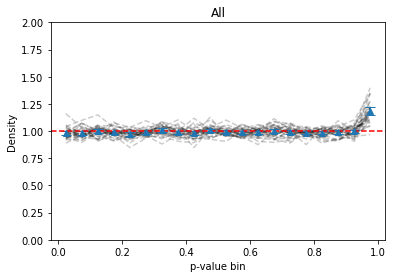

## ('pval', 500)

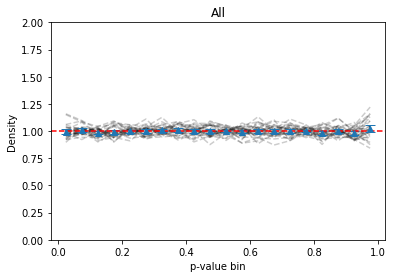

## ('pval', 1000)

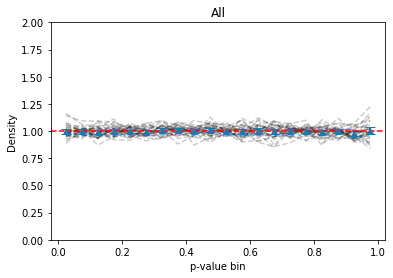

## ('trait_ep', 100)

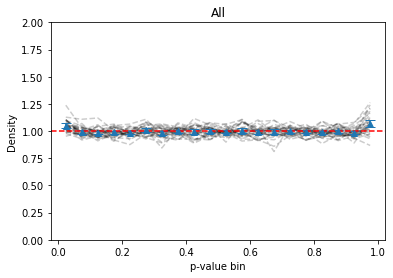

## ('trait_ep', 500)

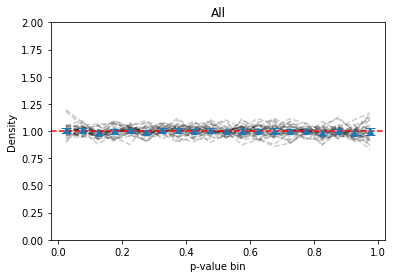

## ('trait_ep', 1000)

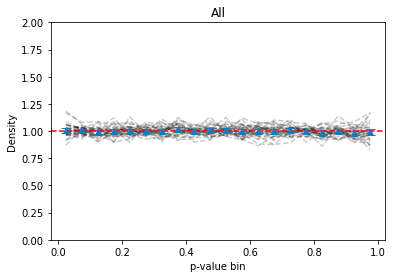

In [51]:
random_trait_names = [f'random_{i}' for i in range(30)]
# for trait_ep_name in ['pval', 'trait_ep', 'normal_trait_ep', 'robust_trait_ep']:
score_index = result_dict[('random_0', 100)]['index']
for trait_ep_name in ['pval', 'trait_ep']:
    for num_ctrl in [100, 500, 1000]:
        display(Markdown(f'## {trait_ep_name, num_ctrl}'))
        score_list = [result_dict[(trait, num_ctrl)][trait_ep_name] for trait in random_trait_names]
         # extract index from one of the simulation, all simulation index stays the same
        simple_md.plot_simulation_score_hist(score_list, score_index, score_dataset, stratify_by_tissue=False)

## p-value calibration

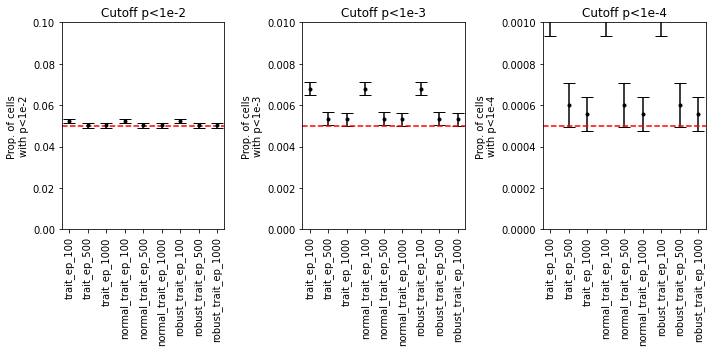

In [52]:
pval_dict = dict()
for name in ['trait_ep', 'normal_trait_ep', 'robust_trait_ep']:
    for num_ctrl in [100, 500, 1000]:
        pval_dict[f'{name}_{num_ctrl}'] = [result_dict[(trait, num_ctrl)][trait_ep_name] for trait in random_trait_names]
simple_md.plot_simulation_pval_calibration(pval_dict)

# Real data analysis

## Association matrix and QQ plot

In [54]:
score_dataset

AnnData object with n_obs × n_vars = 10372 × 19409
    obs: 'cluster_id', 'cell_id', 'celltype', 'n_counts', 'louvain', 'leiden', 'mean', 'var'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'var', 'ct_mean', 'ct_var', 'ct_var_tech', 'var_tech'
    uns: 'diffmap_evals', 'leiden', 'louvain', 'neighbors', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [56]:
df_obs = score_dataset.obs.copy()

In [57]:
df_obs

cluster_id                 cell_id  \
ASGR1_CD45_UNB_P4_5_16         1.0  ASGR1_CD45_UNB_P4_5_16   
ASGR1_CD45_UNB_P4_5_19         1.0  ASGR1_CD45_UNB_P4_5_19   
ASGR1_CD45_UNB_P4_5_26         2.0  ASGR1_CD45_UNB_P4_5_26   
ASGR1_CD45_UNB_P4_5_27         3.0  ASGR1_CD45_UNB_P4_5_27   
ASGR1_CD45_UNB_P4_5_30         4.0  ASGR1_CD45_UNB_P4_5_30   
...                            ...                     ...   
Trop2pos315_3_82               7.0        Trop2pos315_3_82   
Trop2pos315_3_83               4.0        Trop2pos315_3_83   
Trop2pos315_3_89              17.0        Trop2pos315_3_89   
Trop2pos315_3_92               4.0        Trop2pos315_3_92   
Trop2pos315_3_96               7.0        Trop2pos315_3_96   

                                               celltype     n_counts louvain  \
ASGR1_CD45_UNB_P4_5_16              NK, NKT and T cells  2402.648438       5   
ASGR1_CD45_UNB_P4_5_19              NK, NKT and T cells  2702.333496       0   
ASGR1_CD45_UNB_P4_5_26                   Kupffer cells   3595.559082      12   
ASGR1_CD45_UNB_P4_5_27              NK, NKT and T cells  2295.620850       5   
ASGR1_CD45_UNB_P4_5_30  EPCAM+ cells and choalngiocytes  7771.759277       2   
...                                                 ...          ...     ...   
Trop2pos315_3_82        EPCAM+ cells and choalngiocytes  5001.402832       2   
Trop2pos315_3_83        EPCAM+ cells and choalngiocytes  9781.393555       2   
Trop2pos315_3_89                            hepatocytes  3158.094727       2   
Trop2pos315_3_92        EPCAM+ cells and choalngiocytes  6068.219238       2   
Trop2pos315_3_96        EPCAM+ cells and choalngiocytes  4240.453125       2   

                       leiden      mean       var  
ASGR1_CD45_UNB_P4_5_16      0  0.218327  0.863703  
ASGR1_CD45_UNB_P4_5_19      0  0.228893  0.873712  
ASGR1_CD45_UNB_P4_5_26     14  0.264155  1.004929  
ASGR1_CD45_UNB_P4_5_27      0  0.212948  0.869614  
ASGR1_CD45_UNB_P4_5_30      1  0.404020  1.129622  
...                       ...       ...       ...  
Trop2pos315_3_82            1  0.379334  1.192872  
Trop2pos315_3_83            1  0.454194  1.097886  
Trop2pos315_3_89           16  0.282187  1.354042  
Trop2pos315_3_92            1  0.379397  1.073436  
Trop2pos315_3_96            1  0.339691  1.160194  

[10372 rows x 8 columns]

### trait_ep, 500

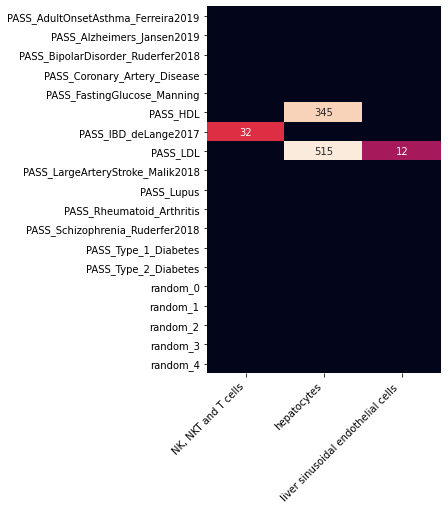

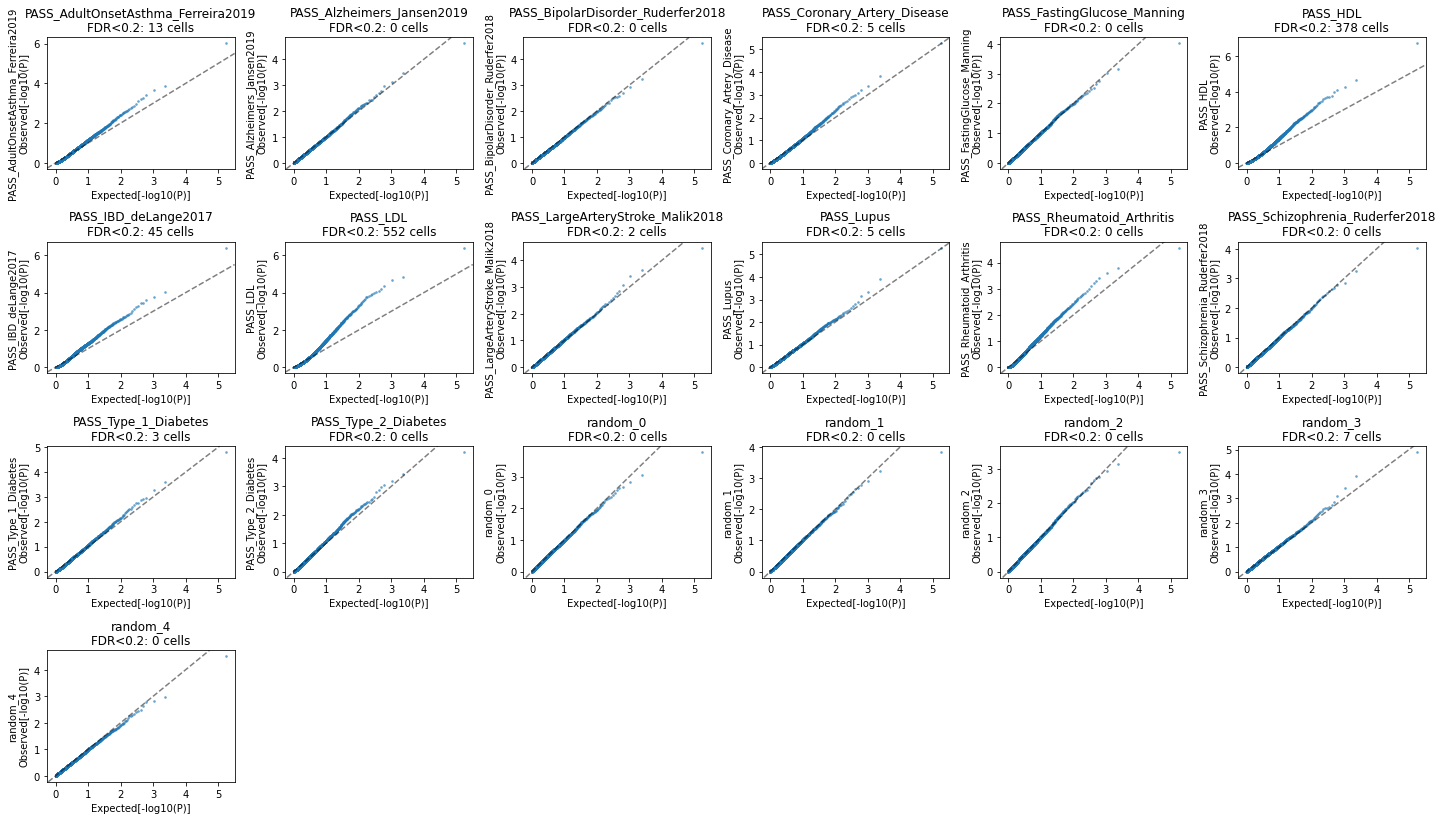

### trait_ep, 1000

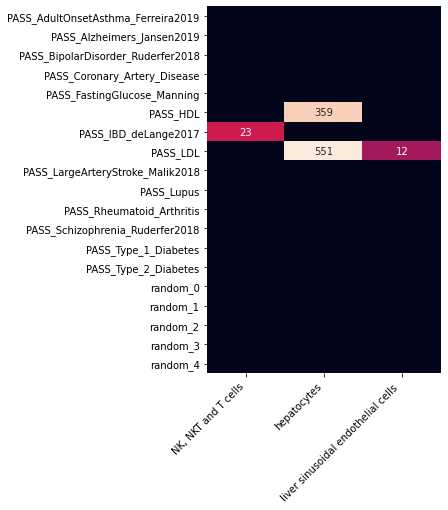

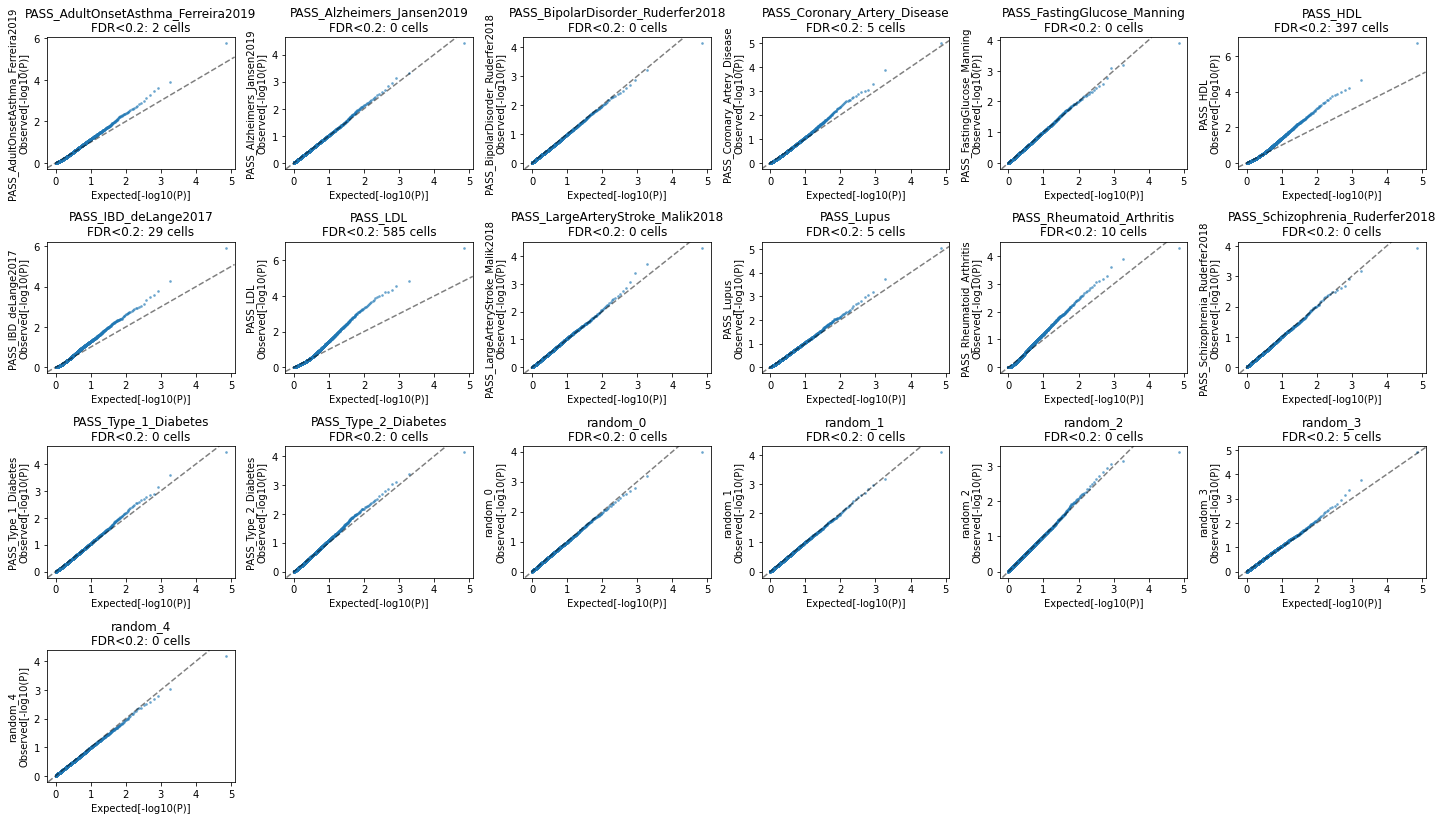

### normal_trait_ep, 500

No association


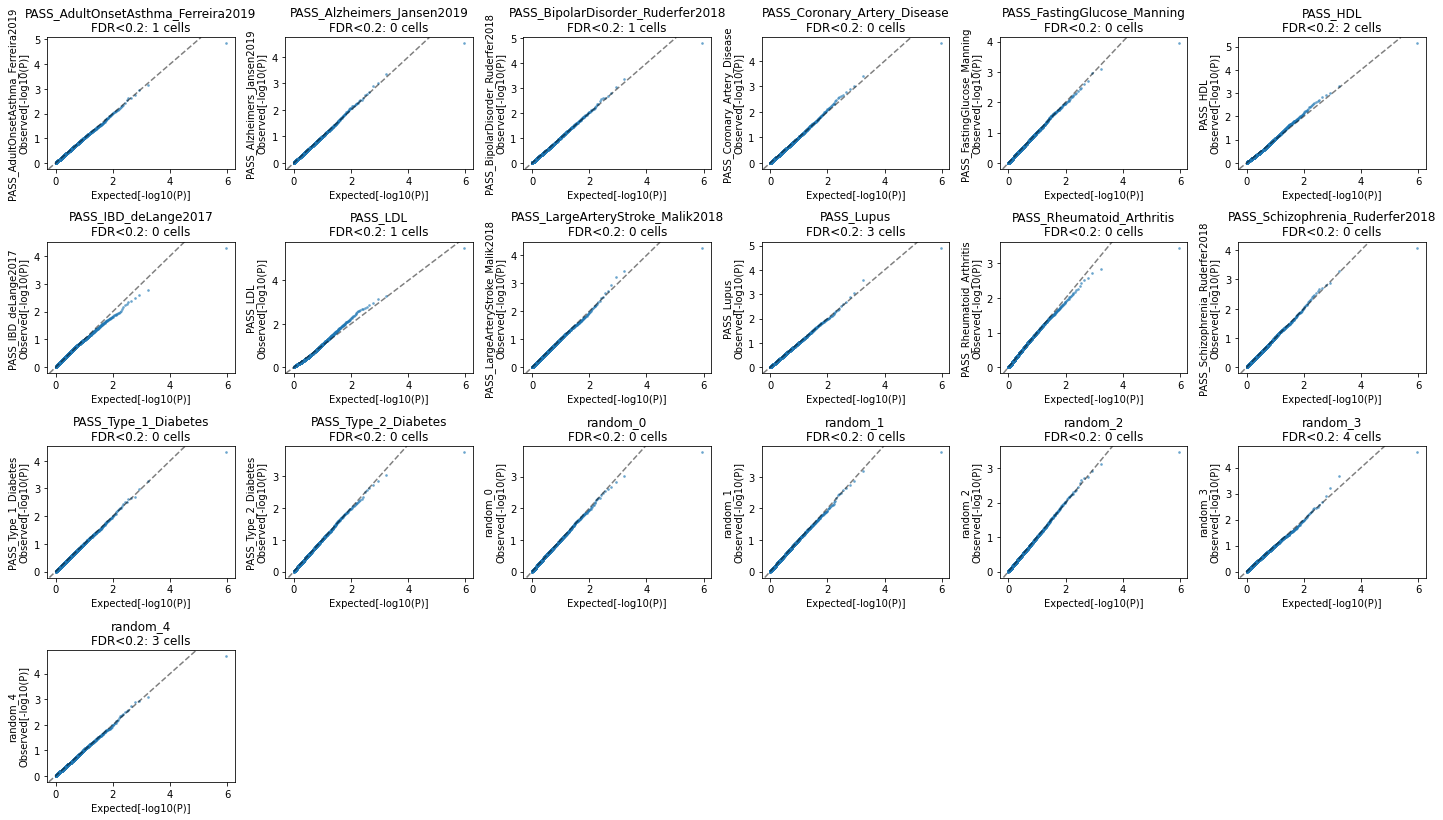

### normal_trait_ep, 1000

No association


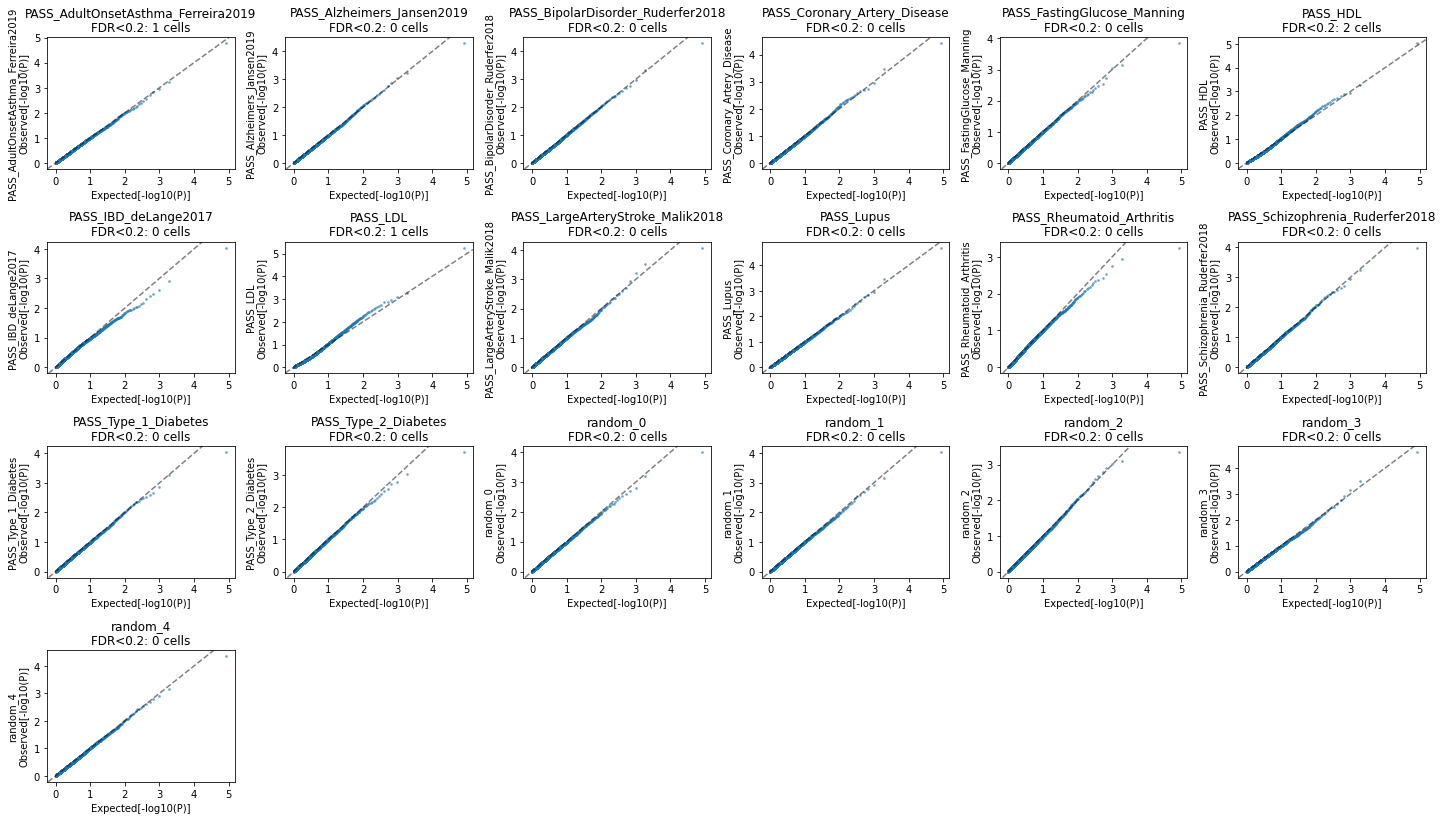

In [66]:
real_trait_names = list(np.unique([trait[0] for trait in result_dict.keys() if not trait[0].startswith('random')]))
score_index = result_dict[('random_0', 100)]['index']

for opt in ['trait_ep', 'normal_trait_ep']:
    for num_ctrl in [500, 1000]:
        display(Markdown(f'### {opt}, {num_ctrl}'))
        pval_dict = {trait: result_dict[(trait, num_ctrl)][opt] for trait in [*real_trait_names, *[f'random_{i}' for i in range(5)] ]}
        simple_md.plot_assoc_matrix(pval_dict, score_index, score_dataset, stratify_by='celltype')
        simple_md.plot_qqplot(pval_dict, num_cols=6)

## p-value UMAP

In [67]:
# load data
umap_adata = dl.load_aizarani_raw_data(opt='processed')

### trait_ep, 500

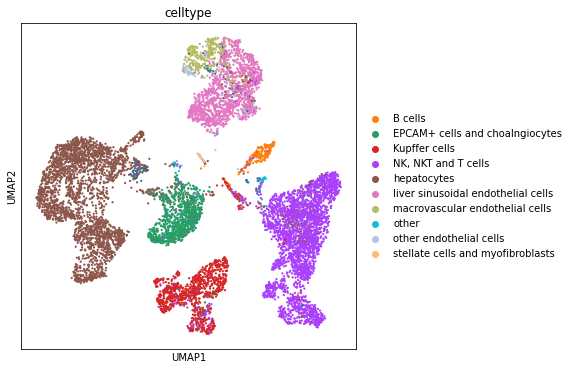

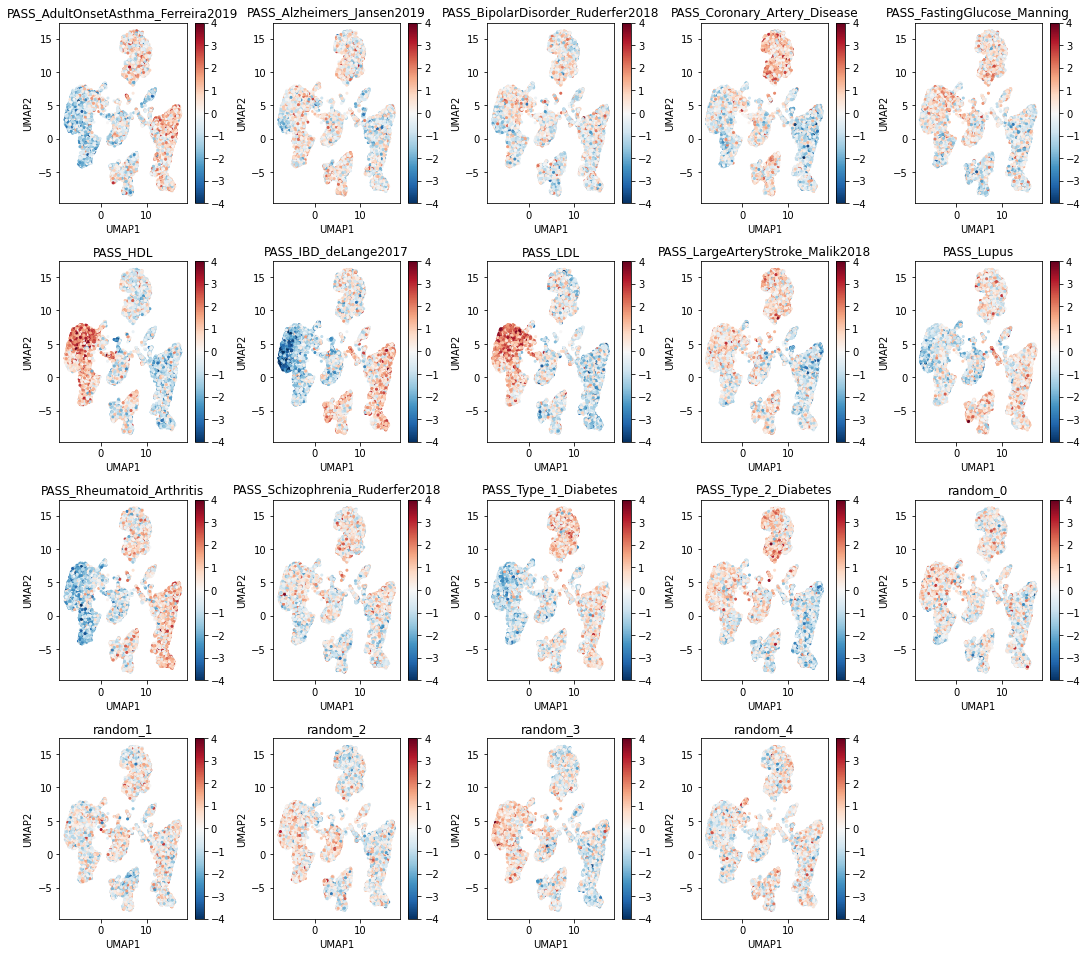

### normal_trait_ep, 500

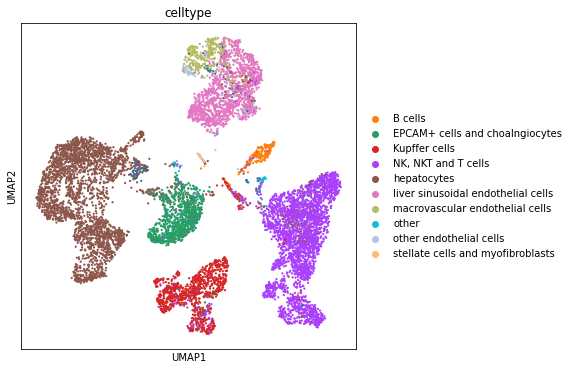

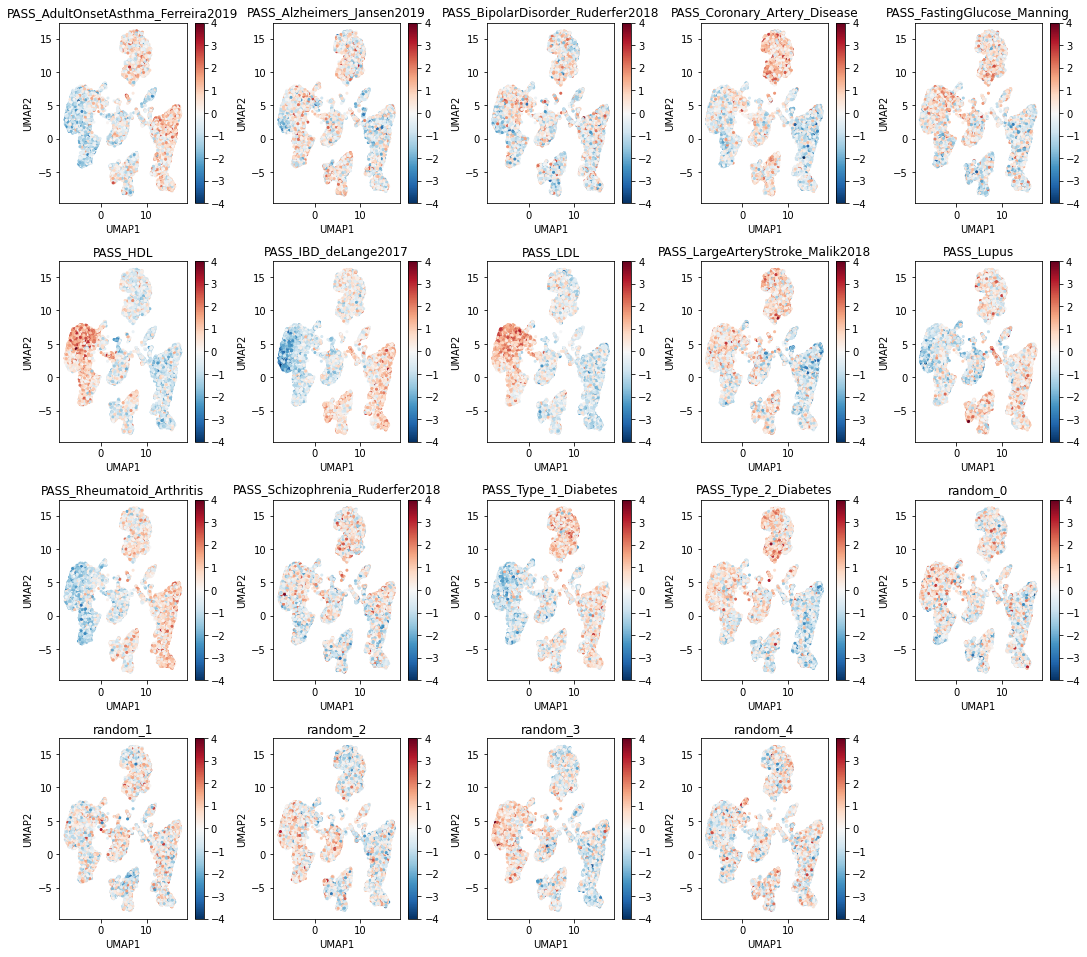

In [72]:
real_trait_names = list(np.unique([trait[0] for trait in result_dict.keys() if not trait[0].startswith('random')]))
score_index = result_dict[('random_0', 100)]['index']

for opt in ['trait_ep', 'normal_trait_ep']:
    for num_ctrl in [500]:
        display(Markdown(f'### {opt}, {num_ctrl}'))
        pval_dict = {trait: result_dict[(trait, num_ctrl)][opt] for trait in [*real_trait_names, *[f'random_{i}' for i in range(5)] ]}
        simple_md.plot_pval_umap(pval_dict, score_index, {'': umap_adata}, umap_color=['celltype'])

# TRS correlation analysis 

### trait_ep, 500

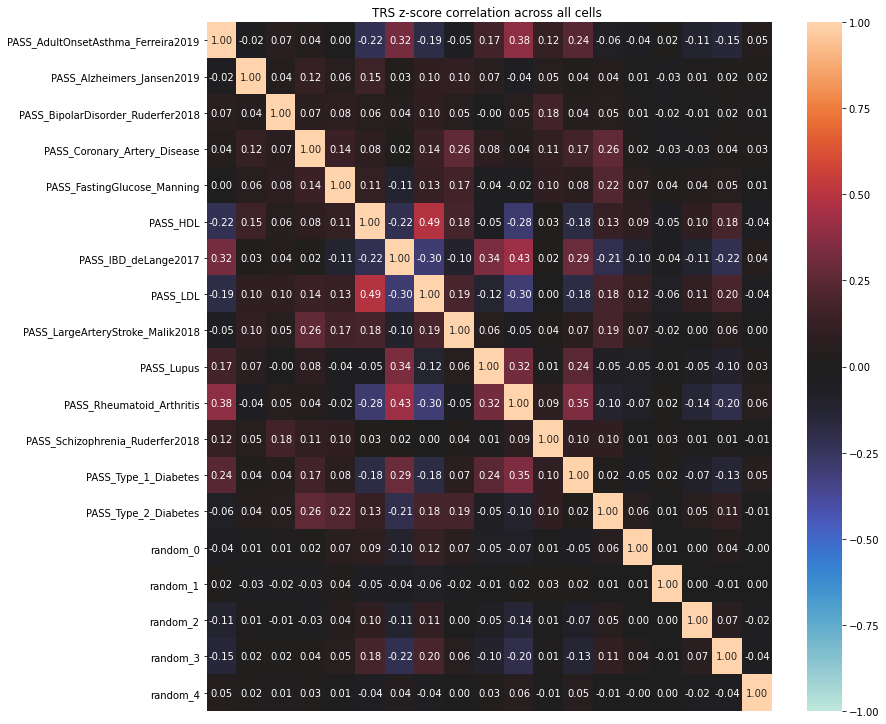

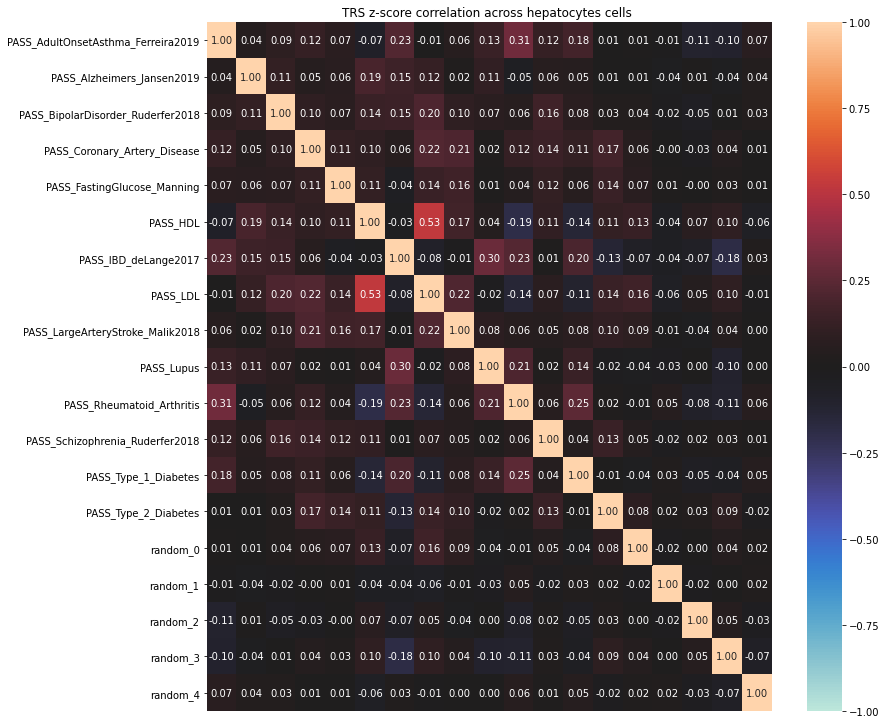

### trait_ep, 1000

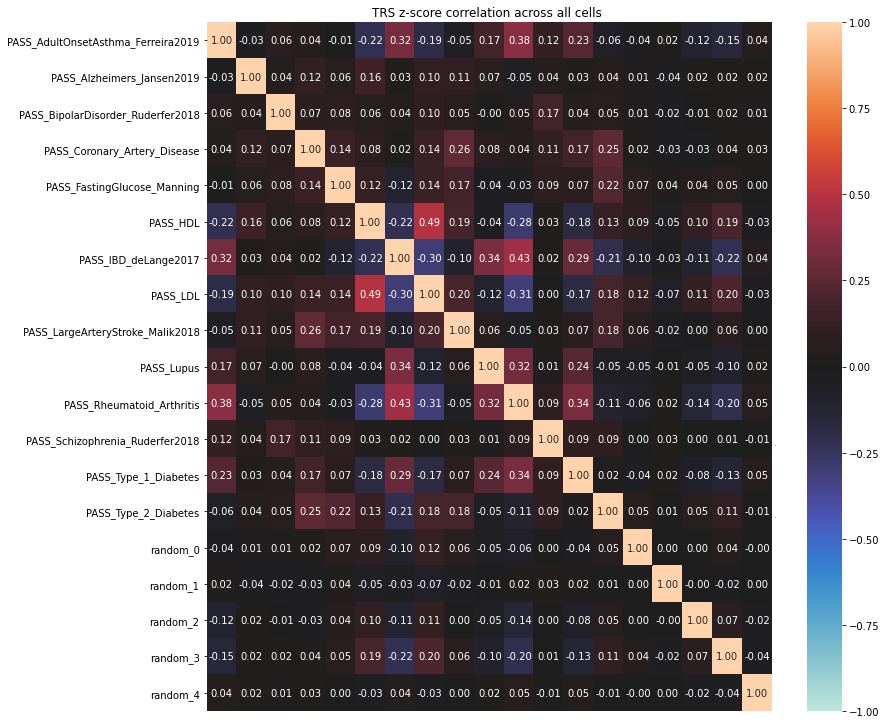

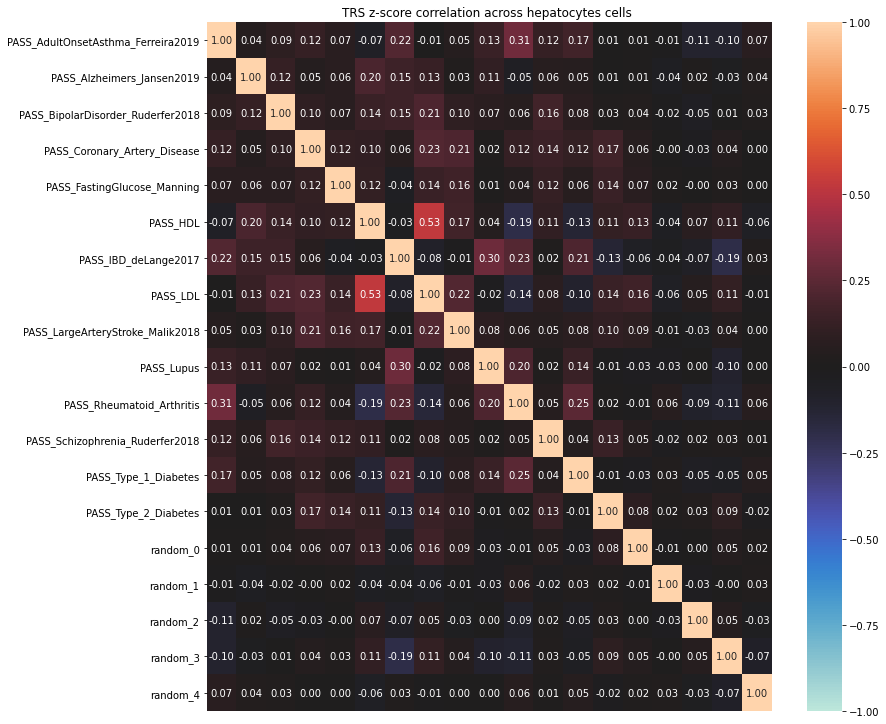

### normal_trait_ep, 500

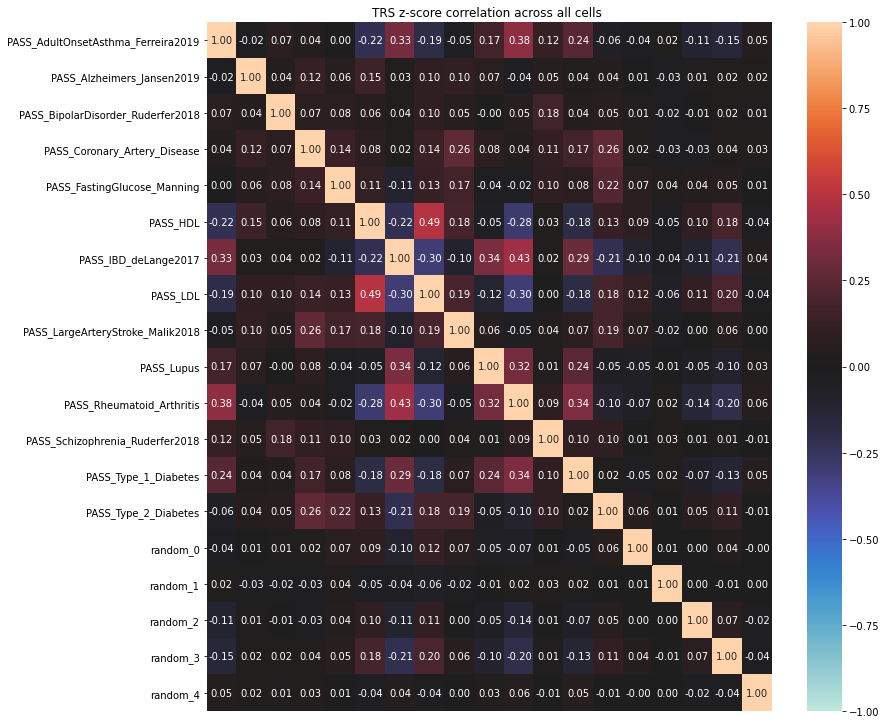

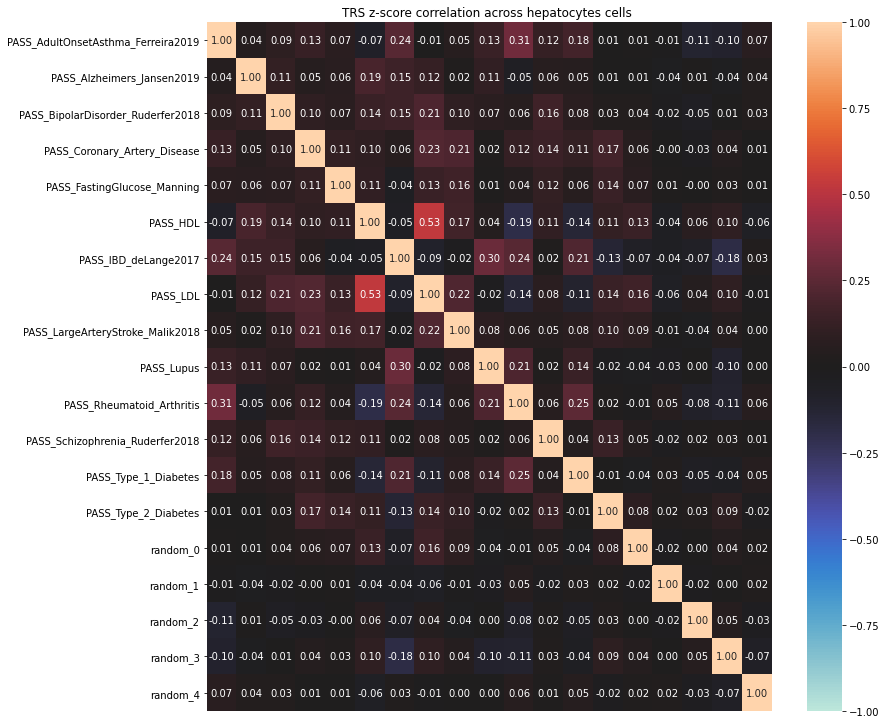

### normal_trait_ep, 1000

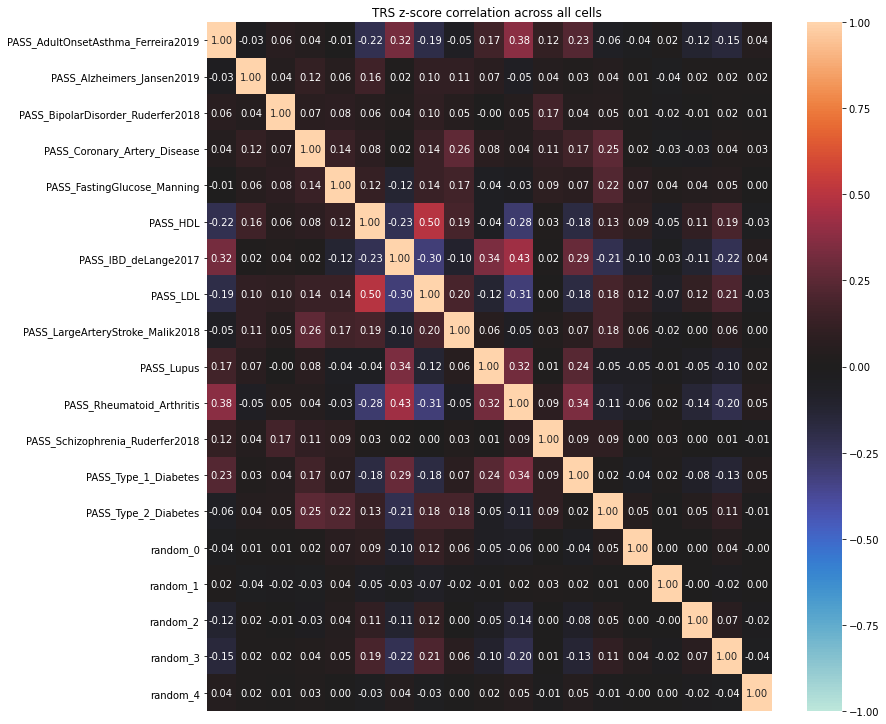

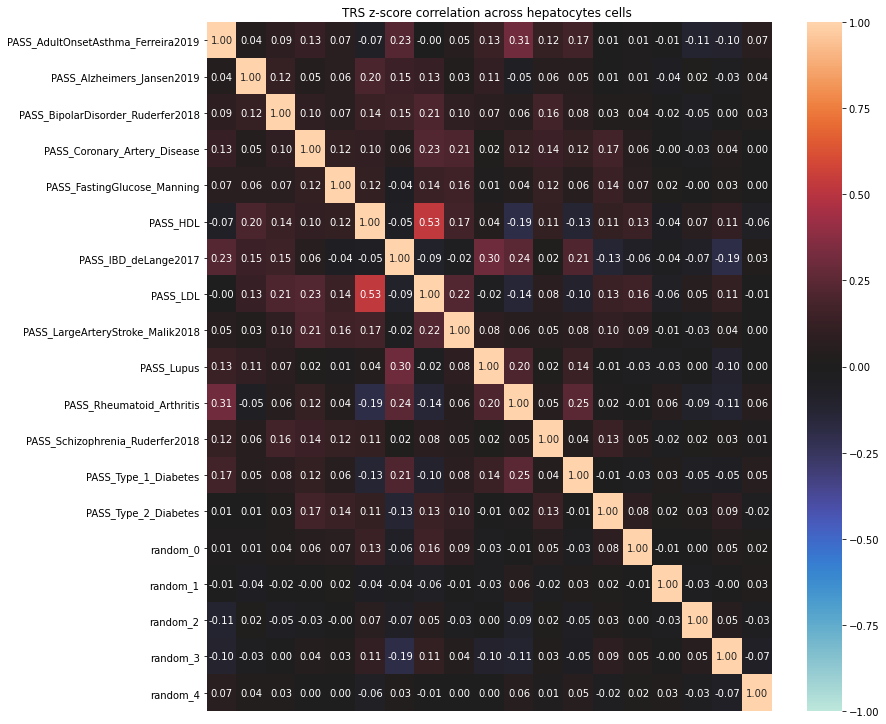

In [80]:
real_trait_names = list(np.unique([trait[0] for trait in result_dict.keys() if not trait[0].startswith('random')]))
plot_trait_names = [*real_trait_names, *[f'random_{i}' for i in range(5)]]
score_index = result_dict[('random_0', 100)]['index']


for opt in ['trait_ep', 'normal_trait_ep']:
    for num_ctrl in [500, 1000]:
        display(Markdown(f'### {opt}, {num_ctrl}'))
        zsc_dict = {trait: simple_md.pval2zsc(result_dict[(trait, num_ctrl)][opt]) for trait in plot_trait_names}
        simple_md.plot_score_correlation(zsc_dict, score_index, score_dataset, {'all': True, 'celltype': ['hepatocytes']})